In [3]:
!pip install scipy==1.9.3 --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stumpy 1.13.0 requires scipy>=1.10, but you have scipy 1.9.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
blosc2 3.4.0 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.9.3 which is incompatible.
albumentations 2.0.8 requires scipy>=1.10.0, but you have scipy 1.9.3 which is incompatible.
xarray-einstats 0.9.0 requires scipy>=1.11, but you have scipy 1.9.3 which is incompatible.
cvxpy 1.6.6 requires scipy>=1.11.0, but you have scipy 1.9.3 which is incompatible.
imbalanced-learn 0.13.0 requires scipy

In [4]:
!pip install catboost

In [5]:
!pip install feature_engine

In [6]:
!pip install plot-metric --quiet

In [7]:
import pandas as pd
import numpy as np
import warnings
import joblib
import plotly.express as px
from google.colab import drive
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from plot_metric.functions import BinaryClassification
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500

from google.colab import auth
import gspread
from google.auth import default
from google.cloud import bigquery
client = bigquery.Client(project='dev-sd-lake')

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [8]:
import json
data = {
  "account": "",
  "client_id": "764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com",
  "client_secret": "d-FL95Q19q7MQmFpd7hHD0Ty",
  "quota_project_id": "dev-sd-lake",
  "refresh_token": "1//05nz9IRnR1e2JCgYIARAAGAUSNwF-L9Ir_zi7EkfNFJb02e5XxL3e4Qicf7BN708CjMo66DuPPMhkd09jS6lIra-zubUPFGORcyU",
  "type": "authorized_user",
  "universe_domain": "googleapis.com"
}
json_data = json.dumps(data)
!echo '{json_data}' > '/content/.config/application_default_credentials.json'

In [9]:
product_listings_query = """
SELECT * FROM pollen.product_listings;
"""
product_listings = client.query_and_wait(product_listings_query).to_dataframe()


products_query = """
SELECT * FROM pollen.products;
"""
products = client.query_and_wait(products_query).to_dataframe()


product_categories_query = """
SELECT * FROM pollen.product_categories;
"""
product_categories = client.query_and_wait(product_categories_query).to_dataframe()


product_subcategories_query = """
SELECT * FROM pollen.product_subcategories;
"""
product_subcategories = client.query_and_wait(product_subcategories_query).to_dataframe()


sellers_query = """
SELECT * FROM pollen.sellers;
"""
sellers = client.query_and_wait(sellers_query).to_dataframe()

In [10]:
offers_query = """
SELECT * FROM pollen.offers;
"""
offers = client.query_and_wait(offers_query).to_dataframe()

In [11]:
orders_level_1_query = """
SELECT * FROM pollen.orders_level_1;
"""
orders_level_1 = client.query_and_wait(orders_level_1_query).to_dataframe()

In [12]:
orders_level_2_query = """
SELECT * FROM pollen.orders_level_2;
"""
orders_level_2 = client.query_and_wait(orders_level_2_query).to_dataframe()

In [13]:
sellers = sellers[['seller_name', 'persona_seller_type']].drop_duplicates()

In [14]:
print(product_listings.shape, products.shape, product_categories.shape, product_subcategories.shape, sellers.shape, offers.shape)

(182283, 41) (182291, 9) (30, 3) (223, 4) (109, 2) (18167, 43)


In [15]:
def get_order_date(df_order_sheet1, df_order_sheet2):
  order_date_to_tracking_no_mapping = df_order_sheet1[['tracking_no', 'order_date']].drop_duplicates()
  df_order_sheet2 = pd.merge(df_order_sheet2, order_date_to_tracking_no_mapping, 'left',  on = ['tracking_no'])
  df_order_sheet2.drop('date_of_order', axis = 1, inplace = True)
  df_order = df_order_sheet2.copy()
  return df_order

orders = get_order_date(orders_level_1, orders_level_2)

In [16]:
orders = orders.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
offers = offers.drop_duplicates(subset = ['sku_number', 'expiry_date', 'tracking_no'])
offers = offers.rename(columns = {'total_units' : 'total_units_offered'})
orders = orders.rename(columns = {'total_units' : 'total_units_ordered', 'total_offer_price_usd' : 'total_order_price_usd'})

offers = pd.merge(offers, orders[['sku_number', 'expiry_date', 'tracking_no', 'total_units_ordered', 'recovery_rate_percentage',
                                  'total_order_price_usd', 'domestic_export']], 'left', on = ['sku_number', 'expiry_date', 'tracking_no'])

In [17]:
product_subcategories = product_subcategories.rename(columns = {'id' : 'subcategory_id', 'name' : 'product_subcategory'})
product_categories = product_categories.rename(columns = {'id' : 'category_id', 'name' : 'product_category'})

products = pd.merge(products, product_categories, 'left', on = 'category_id')
products = pd.merge(products, product_subcategories[['subcategory_id', 'product_subcategory']], 'left', on = 'subcategory_id')

In [18]:
products = products.rename(columns = {'id' : 'product_id'})
products = products.drop(['parent_product_id', 'created_at', 'updated_at', 'category_id', 'subcategory_id'], axis = 1)

product_listings = product_listings.drop(['created_at', 'updated_at', 'pollen_updated_price_per_unit_local',
                       'barcode', 'barcode_key', 'manufactured_date', 'batch_number', 'image_links', 'usd_conversion', 'scoring'], axis = 1)
product_listings = pd.merge(product_listings, products, 'left', on = 'product_id')

In [19]:
product_listings.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_number_of_items,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory
0,2d61c777-e0d5-4744-b9eb-dd24f74ee061,44642cbd-8752-4f55-a368-669f22e9e8f8,SE1712631761502,SE1712631761502G4311200,L'Oreal Indonesia,2025-01-01,Carton,64.20,60.0,3852.0,IDR,24900.0,5991.5,31.0,g,0.01,254.0,156.0,219.0,MM,2.24,Bekasi,Indonesia,-,-,NaN,P2,1.53,0.37,CORE,2024-05-28,G4311200,GRN 2 STEP PW MASK B5 GOJI EB,GARNIER,SKIN CARE,SKIN CARE,MASKS & EXFOLIATORS
1,41508680-7c85-47aa-a54c-2bcbbddb56e9,6ca31813-8cac-4459-a53e-d68b62bf337d,SE1712631761502,SE1712631761502G4218000,L'Oreal Indonesia,2025-01-28,Carton,58.43,60.0,3506.0,IDR,23400.0,6552.7,19.7,g,0.01,185.0,150.0,197.0,MM,1.42,Bekasi,Indonesia,-,-,NaN,P2,1.44,0.40,CORE,2024-05-28,G4218000,GRN 5 MIN AMP MASK WATERMELON EB,GARNIER,SKIN CARE,SKIN CARE,MASKS & EXFOLIATORS


In [20]:
product_listings.inventory_class.value_counts()

,count
inventory_class,
NON_CORE,115580
CORE,66703


In [21]:
# from google.colab import files
# sku_cat_and_sub_cat_combinations = product_listings[['sku_number', 'sku_product_name', 'product_category', 'product_subcategory']].drop_duplicates()
# sku_cat_and_sub_cat_combinations.to_csv('sku_cat_and_sub_cat_combinations.csv')
# files.download('sku_cat_and_sub_cat_combinations.csv')

In [22]:
df_inv = product_listings[product_listings.inventory_class == 'CORE']
non_core_inv = product_listings[product_listings.inventory_class == 'NON_CORE']
df_inv = df_inv.reset_index(drop = True)
non_core_inv = non_core_inv.reset_index(drop = True)

In [23]:
cols_list_underscore_cleaning = ['sku_product_name', 'brand', 'product_category', 'product_subcategory', 'warehouse_country',
            'country_of_origin', 'pack_label_language', 'product_restricted_countries', 'shelf_life_bucket']

inv_cols_list_to_change_dtypes = ['qty_of_cartons', 'units_per_cartons', 'retail_price_per_case_(local)', 'retail_price_per_case_(usd)', 'asking_price_per_case_(local)',
                              'asking_price_per_case_(usd)', 'total_retail_price_(local)', 'total_retail_price_(usd)', 'total_asking_price_(local)',
                              'total_asking_price_(usd)', 'pack_size_(number)', 'total_cbm', 'cbm_per_case', 'package_dimensions_per_package_type_(length)',
                              'package_dimensions_per_case_(width)', 'package_dimensions_per_case_(height)', 'net_weight_\nper_unit(kg)', 'net_weight_per_case_(kg)',
                              'gross_weight_per_case_(kg)', 'total_net_weight_(kg)', 'total_gross_weight_(kg)', 'cases_per_pallet', 'number_of_pallets', 'discount',
                              'shelf_remaining_days']

record_attributes = ['sku_number', 'sku_name', 'brand', 'product_category', 'product_subcategory', 'retail_price_per_unit_local', 'currency']

n_days_before_date = pd.to_datetime(date.today() - timedelta(days = 14))

THRESHOLD = 0.65

In [24]:
def dropping_null_brand_cat_subcats(df_inv):
  df_inv = df_inv[~df_inv.brand.isnull()]
  df_inv = df_inv[~df_inv.product_category.isnull()]
  df_inv = df_inv[~df_inv.product_subcategory.isnull()]
  return df_inv

def cols_to_lower_rem_space(df, cols_list):
  for col in ['sku_name', 'product_name', 'brand', 'brand_', 'product_description', 'product_category', 'product_sub_category', 'product_subcategory',\
              'warehouse_location', 'buyer', 'seller', 'package_type', 'deal_type', 'origin_', 'destination', 'region_of_export', \
              'domestic_export', 'order_type', 'country', 'currency', 'country_of_origin', 'pack_label_language', 'dangerous_goods\n(y/n)', 'shelf_life_bucket',
              'relavant_(r)/ir-relavant(ir)', 'product_restricted_countries', 'store_name', 'quarter', 'temp_reference', 'tracking_no', 'offer_type', 'fiscal_month',
              'proposed_buyer_product_preferences', 'product_shelf_life_months', 'priority', 'seller', 'lms_seller_id', 'persona', 'core_vs._\nnon_core', 'sku_product_name',
              'warehouse_country', 'warehouse_address', 'measurement_units', 'listing_currency', 'manufacturing_country', 'lbh_measurement_units', 'package_type', 'seller_name',
              'pack_size_unit', 'package_labeled_language', 'inventory_class', 'description', 'unit_dimensions']:
              if col in cols_list:
                df[col] = df[col].str.lower().str.replace(' ', '_')
  return df

def remove_starting_and_trailing_underscores(x):
  if x != '':
    if x[0] == '_':
      for i in range(len(x)):
        if x[i] != '_':
          start = i
          break
      x = x[start:]
    if x[-1] == '_':
      for i in reversed(range(len(x))):
        if x[i] != '_':
          end = i
          break
      x = x[:end+1]
  return x

def cleaning_underscores_inv_data(df_inv, col_list):
  for col in col_list:
    print(col)
    df_inv[col] = df_inv[col].apply(remove_starting_and_trailing_underscores)
  return df_inv

def drop_dups_and_clean(df_inv):
  print('Dropping above duplicates ...')
  df_inv = df_inv.drop_duplicates()
  return df_inv

# Non core

In [25]:
df_inv = dropping_null_brand_cat_subcats(df_inv)
df_inv = cols_to_lower_rem_space(df_inv, df_inv.columns)
df_inv = drop_dups_and_clean(df_inv)

non_core_inv = cols_to_lower_rem_space(non_core_inv, non_core_inv.columns)

Dropping above duplicates ...


In [26]:
non_core_inv.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_number_of_items,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory
0,b61c2bb9-f203-4447-bd21-34c8b2d8a03a,c741e020-cae7-4258-b71f-3bc338b38412,SE1712631761542,SE171263176154204R3I1MKJPD97H7OBZ60UTU1Z,acommerce_singapore,2023-05-31,pieces,NaN,NaN,6.0,sgd,19.9,1.99,NaN,None,0.0,10.0,10.0,10.0,cm,0.50,sg-acom01,None,None,None,NaN,p1,15.116504,1.511650,non_core,2023-01-25,04R3I1MKJPD97H7OBZ60UTU1Z,l'oreal_paris_color_riche_satin_105_nude_in_paris,l'oreal_paris,makeup,makeup,lip_makeup
1,329218a0-49c7-4e36-bfe7-e10d17de8dfc,0cec2d8c-024a-4929-87fa-358f264016b7,SE1712631761542,SE171263176154211YAP8LR1W3OQSFJGWCLTD1DQ,acommerce_singapore,2023-05-31,pieces,NaN,NaN,160.0,sgd,2.0,0.20,NaN,None,0.0,8.0,5.0,0.2,cm,0.15,sg-acom02,None,None,None,NaN,p1,1.519247,0.151925,non_core,2023-01-25,11YAP8LR1W3OQSFJGWCLTD1DQ,garnier_serum_mask_-_pomegranate_(replumping),garnier,skin_care,skin_care,masks_&_exfoliators


In [27]:
non_core_inv = non_core_inv.rename(columns = {'total_number_of_items' : 'total_units'})
non_core_inv['updated_on'] = pd.to_datetime(non_core_inv['updated_on'])
non_core_inv['expiry_date'] = pd.to_datetime(non_core_inv['expiry_date'])

In [28]:
print(non_core_inv.shape)
non_core_inv = non_core_inv.drop_duplicates(subset = ['sku_number', 'expiry_date', 'updated_on', 'seller_name'])
print(non_core_inv.shape)

(115580, 37)
(64433, 37)


In [29]:
offers = offers.rename(columns = {'seller' : 'seller_name'})
offers['date_of_offer'] = pd.to_datetime(offers['date_of_offer'])
offers['seller_name'] = offers['seller_name'].str.lower()
offers['total_units_ordered'] = offers['total_units_ordered'].str.replace(',', '')
offers['total_units_ordered'] = offers['total_units_ordered'].astype(float)

In [30]:
def merge_non_core_inv_and_offer(non_core_inv, df_offer):
  temp = pd.merge(non_core_inv, df_offer[['sku_number', 'seller_name', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'total_units_ordered',
                                          'recovery_rate_percentage', 'offer_price_per_unit_usd', 'total_order_price_usd', 'domestic_export']], 'left', on = ['sku_number', 'seller_name'])
  # temp['updated_on'] = pd.to_datetime(temp['updated_on'])
  temp['offer_day_diff_updated_inv'] = (temp['date_of_offer'] - temp['updated_on']).dt.days
  # avoiding future entry from same sku and seller to get filtered out hence nulling it as will remain in the dataframe
  temp['offer_day_diff_updated_inv'] = np.where(temp.offer_day_diff_updated_inv < 0, np.nan, temp['offer_day_diff_updated_inv'])
  temp = temp[(temp.offer_day_diff_updated_inv >= 0) | (temp.offer_day_diff_updated_inv.isnull())]
  df_non_core_inv_min_offer_day_diff_updated_inv = temp.groupby(['sku_number', 'seller_name', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                        .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  temp = pd.merge(temp, df_non_core_inv_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'seller_name', 'date_of_offer'])
  temp = temp[(temp.offer_day_diff_updated_inv == temp.min_offer_day_diff_updated_inv) | (temp.offer_day_diff_updated_inv.isnull())]
  temp.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return temp

In [31]:
non_core_inv = merge_non_core_inv_and_offer(non_core_inv, offers)
non_core_inv['total_units_ordered'] = non_core_inv['total_units_ordered'].fillna(0)
non_core_inv['sell_thru_rate'] = non_core_inv['total_units_ordered'] / non_core_inv['total_units']
non_core_inv['sell_thru_rate'] = np.where(non_core_inv['sell_thru_rate'] > 1, 1, non_core_inv['sell_thru_rate'])
non_core_inv['shelf_life_remaining_days'] = (non_core_inv['expiry_date'] - non_core_inv['updated_on']).dt.days

In [32]:
def remove_percent_sign(x):
  if pd.isna(x):
    return x
  else:
    return x[:-1]
non_core_inv['recovery_rate_percentage'] = non_core_inv['recovery_rate_percentage'].apply(remove_percent_sign)
non_core_inv['recovery_rate_percentage'] = np.where(non_core_inv['recovery_rate_percentage'] == '', np.nan, non_core_inv['recovery_rate_percentage'])
non_core_inv['recovery_rate_percentage'] = non_core_inv['recovery_rate_percentage'].astype(float)
non_core_inv['recovery_rate_percentage'] = np.where(non_core_inv['recovery_rate_percentage'].isnull(), 0 , non_core_inv['recovery_rate_percentage'])

In [33]:
non_core_inv.head(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory,date_of_offer,actual,tracking_no,buyer,total_units_ordered,recovery_rate_percentage,offer_price_per_unit_usd,total_order_price_usd,domestic_export,offer_day_diff_updated_inv,sell_thru_rate,shelf_life_remaining_days
0,b61c2bb9-f203-4447-bd21-34c8b2d8a03a,c741e020-cae7-4258-b71f-3bc338b38412,SE1712631761542,SE171263176154204R3I1MKJPD97H7OBZ60UTU1Z,acommerce_singapore,2023-05-31,pieces,NaN,NaN,6.0,sgd,19.9,1.99,NaN,None,0.0,10.0,10.0,10.0,cm,0.50,sg-acom01,None,None,None,NaN,p1,15.116504,1.511650,non_core,2023-01-25,04R3I1MKJPD97H7OBZ60UTU1Z,l'oreal_paris_color_riche_satin_105_nude_in_paris,l'oreal_paris,makeup,makeup,lip_makeup,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,126.0
1,329218a0-49c7-4e36-bfe7-e10d17de8dfc,0cec2d8c-024a-4929-87fa-358f264016b7,SE1712631761542,SE171263176154211YAP8LR1W3OQSFJGWCLTD1DQ,acommerce_singapore,2023-05-31,pieces,NaN,NaN,160.0,sgd,2.0,0.20,NaN,None,0.0,8.0,5.0,0.2,cm,0.15,sg-acom02,None,None,None,NaN,p1,1.519247,0.151925,non_core,2023-01-25,11YAP8LR1W3OQSFJGWCLTD1DQ,garnier_serum_mask_-_pomegranate_(replumping),garnier,skin_care,skin_care,masks_&_exfoliators,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,126.0


# Core

In [34]:
offers = offers.rename(columns = {'seller_name' : 'seller_short'})

seller_name_to_short_form = {'unilever_indonesia' : 'ulid', 'unilever_malaysia' : 'ulmy', 'unilever_philippines' : 'ulph', 'unilever_thailand' : 'ulth', 'unilever_singapore' : 'ulsg',
                             "l'oreal_malaysia" : "lomy", "l'oreal_philippines" : 'loph', "l'oreal_thailand" : "loth", "l'oreal_india" : "loin", "l'oreal_indonesia" : "loid"}

df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])

def apply_seller_short(x):
  if x in seller_name_to_short_form.keys():
    return seller_name_to_short_form[x]
  else:
    return x

df_inv['seller_short'] = df_inv['seller_name'].apply(apply_seller_short)

offers = offers[offers['expiry_date'] != '-']
offers['expiry_date'] = pd.to_datetime(offers['expiry_date'], format = "%d-%b-%Y")
df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])

In [35]:
def merge_inv_and_offer(df_inv, df_offer):
  df_inv = pd.merge(df_inv, df_offer[['sku_number', 'expiry_date', 'seller_short', 'date_of_offer', 'actual', 'tracking_no', 'buyer', 'total_units_ordered',
                                      'recovery_rate_percentage', 'offer_price_per_unit_usd', 'total_order_price_usd', 'domestic_export']], 'left', on = ['sku_number', 'expiry_date', 'seller_short'])
  df_inv['offer_day_diff_updated_inv'] = (df_inv['date_of_offer'] - df_inv['updated_on']).dt.days
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv >= 0) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_min_offer_day_diff_updated_inv = df_inv.groupby(['sku_number', 'expiry_date', 'seller_short', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                      .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  df_inv = pd.merge(df_inv, df_min_offer_day_diff_updated_inv, 'left', on = ['sku_number', 'expiry_date', 'seller_short', 'date_of_offer'])
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv == df_inv.min_offer_day_diff_updated_inv) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_inv.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return df_inv

In [36]:
df_inv = merge_inv_and_offer(df_inv, offers)
df_inv['total_units_ordered'] = df_inv['total_units_ordered'].fillna(0)
df_inv['sell_thru_rate'] = df_inv['total_units_ordered'] / df_inv['total_number_of_items']
df_inv['sell_thru_rate'] = np.where(df_inv['sell_thru_rate'] > 1, 1, df_inv['sell_thru_rate'])
df_inv['shelf_life_remaining_days'] = (df_inv['expiry_date'] - df_inv['updated_on']).dt.days

In [37]:
def remove_percent_sign(x):
  if pd.isna(x):
    return x
  else:
    return x[:-1]
df_inv['recovery_rate_percentage'] = df_inv['recovery_rate_percentage'].apply(remove_percent_sign)
df_inv['recovery_rate_percentage'] = np.where(df_inv['recovery_rate_percentage'] == '', np.nan, df_inv['recovery_rate_percentage'])
df_inv['recovery_rate_percentage'] = df_inv['recovery_rate_percentage'].astype(float)
df_inv['recovery_rate_percentage'] = np.where(df_inv['recovery_rate_percentage'].isnull(), 0 , df_inv['recovery_rate_percentage'])

In [38]:
# removing some rows which are common on ['sku_number', 'expiry_date', 'seller_short', 'updated_on']. Why ?
# when matching inventory to offers, the inventory which is offered multiple times gets repeated. Which is fine and we wish to consider that
# but there are still some combos in inv which were not offered, buyer is null for them, still they are repeated with almost the same complete row. We need to remove such rows

temp = df_inv[df_inv.duplicated(subset = ['sku_number', 'expiry_date', 'seller_short', 'updated_on'])]
to_remove_ids = temp[temp.buyer.isnull()].id
print(len(to_remove_ids))

5114


In [39]:
df_inv = df_inv[~df_inv.id.isin(to_remove_ids)]
df_inv.shape

(51519, 50)

In [40]:
df_inv = df_inv.rename(columns = {'total_number_of_items' : 'total_units'})
df_inv['updated_on'] = pd.to_datetime(df_inv['updated_on'])
df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])
df_inv = df_inv[df_inv.sku_number != '']
df_inv['seller_name'] = df_inv['seller_short']
df_inv = df_inv.drop('seller_short', axis = 1)

In [41]:
total_inv = pd.concat([df_inv, non_core_inv], ignore_index=True)

In [42]:
def get_target(df):
  df['sellability'] = np.where(df.date_of_offer.isnull(), 0, 1)
  print(df.sellability.value_counts())
  return df

total_inv = get_target(total_inv)

sellability
0    101760
1     14264
Name: count, dtype: int64


In [43]:
total_inv.sample(2)

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory,date_of_offer,actual,tracking_no,buyer,total_units_ordered,recovery_rate_percentage,offer_price_per_unit_usd,total_order_price_usd,domestic_export,offer_day_diff_updated_inv,sell_thru_rate,shelf_life_remaining_days,sellability
78761,54e69167-9e8b-41fa-a7d0-4cf015e14632,63678cf8-f65b-4762-ad03-7100bdab7241,SE1739336674384,SE1739336674384PUMARAPIDOIIITJRLUMINOUSBLUE-PU...,excess2sell,NaT,pieces,NaN,NaN,1.0,inr,2499.0,625.00,NaN,None,NaN,NaN,NaN,NaN,-,NaN,india,india,-,-,NaN,p3,28.775913,7.193978,non_core,2025-02-11,PUMARAPIDOIIITJRLUMINOUSBLUE-PUMABLACK3_SHOES_...,puma_rapido_ii_it_jr_luminous_blue-puma_black_3,puma,"apparels,_footwear,_accessories","apparels,_footwear,_accessories",footwear,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0
87609,7200f0f6-eac3-4f64-9bd0-9f73b78c2999,3044e337-af0b-47fb-bd9d-1a9ccb4e60ae,SE1739336680829,SE1739336680829E2S04415,excess2sell,NaT,pieces,NaN,NaN,1.0,inr,1999.0,505.75,NaN,-,NaN,NaN,NaN,NaN,-,NaN,india,india,-,-,NaN,p3,23.007828,5.821015,non_core,2025-03-03,E2S04415,sequin_partywear_dresspink,other,other,other,kids_tops,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0


In [44]:
def get_order_price_per_unit(df):
  if df['total_units_ordered'] == 0:
    return 0
  else:
    return df['total_order_price_usd'] / df['total_units_ordered']

total_inv['total_order_price_usd'] = total_inv['total_order_price_usd'].str.replace(',', '')
total_inv['total_order_price_usd'] = total_inv['total_order_price_usd'].astype(float)
total_inv['order_price_per_unit_usd'] = total_inv.apply(get_order_price_per_unit, axis = 1)

total_inv['offer_price_per_unit_usd'] = total_inv['offer_price_per_unit_usd'].str.replace(',', '')
total_inv['offer_price_per_unit_usd'] = total_inv['offer_price_per_unit_usd'].astype(float)

In [45]:
total_inv = total_inv[~total_inv['retail_price_per_unit_usd'].isin([0, np.nan])]

In [46]:
total_inv.sample()

,id,product_id,seller_id,record_id,seller_name,expiry_date,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pack_size_number,pack_size_unit,cbm_carton,length,breadth,height,unit_dimensions,weight_per_carton_kg,warehouse_address,warehouse_country,country_of_origin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,inventory_class,updated_on,sku_number,sku_product_name,brand,product_category,description,product_subcategory,date_of_offer,actual,tracking_no,buyer,total_units_ordered,recovery_rate_percentage,offer_price_per_unit_usd,total_order_price_usd,domestic_export,offer_day_diff_updated_inv,sell_thru_rate,shelf_life_remaining_days,sellability,order_price_per_unit_usd
35927,1b885602-1020-43d3-87be-b38f99f2105c,b0e8d832-afd6-4717-a382-17d06aa0e375,SE1712631747494,SE171263174749468806219,ulid,2023-01-07,carton,1.0,12.0,12.0,usd,1.75,0.68,770.0,g,0.03,0.41,0.26,0.27,m,9.24,wdc_cibitung,indonesia,indonesia,bahasa_and_english,NaN,p1,1.75,0.68,core,2022-12-12,68806219,rinso_anti_noda_classic_new_12x770g,rinso,home_care,home_care,laundry,NaT,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,26.0,0,0.0


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans


# Step 2: Columns to exclude from clustering
cols_to_ignore = [
    'id', 'product_id', 'seller_id', 'record_id', 'expiry_date',
    'package_labeled_language', 'product_restriction', 'updated_on',
    'date_of_offer', 'actual', 'tracking_no', 'buyer']

# Step 3: Create clustering dataset
df_cluster = total_inv.drop(columns=cols_to_ignore)

# Step 4: Encode categorical columns (excluding domestic_export)
categorical_cols = df_cluster.select_dtypes(include='object').columns.tolist()
if 'domestic_export' in categorical_cols:
    categorical_cols.remove('domestic_export')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cluster[col] = df_cluster[col].astype(str)
    df_cluster[col] = le.fit_transform(df_cluster[col])
    label_encoders[col] = le

# Step 5: Fill missing values for clustering
df_cluster.fillna(0, inplace=True)

# Step 6: Scale features (excluding domestic_export)
X_features = df_cluster.drop(columns=['domestic_export'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Step 7: Run KMeans with fixed K = 10
k = 100
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
total_inv['cluster'] = kmeans.fit_predict(X_scaled)
print(f"\n KMeans clustering completed with K = {k}")
print('score - ', silhouette_score(X_scaled, total_inv['cluster']))

# Step 8: Impute missing domestic_export values by cluster mode
def impute_domestic_export(row):
    if pd.notna(row['domestic_export']):
        return row['domestic_export']
    cluster_rows = total_inv[(total_inv['cluster'] == row['cluster']) & (total_inv['domestic_export'].notna())]
    if not cluster_rows.empty:
        return cluster_rows['domestic_export'].mode()[0]
    return 'Domestic'  # fallback default

total_inv['domestic_export'] = total_inv.apply(impute_domestic_export, axis=1)

# Optional: Flag imputed rows
total_inv['domestic_export_imputed'] = total_inv['domestic_export'].isna() & total_inv['domestic_export'].notna()

# Step 9: Clean up
total_inv.drop(columns=['cluster'], inplace=True)

# Optional: Count imputed rows
imputed_count = total_inv['domestic_export_imputed'].sum()
print(f"\n Imputed {imputed_count} missing 'domestic_export' values using KMeans clustering.")

total_inv['domestic_export'] = total_inv['domestic_export'].str.lower()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f03dff22200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error



 KMeans clustering completed with K = 100
score -  0.3036837505028182

 Imputed 0 missing 'domestic_export' values using KMeans clustering.


In [48]:
total_inv['domestic_export'].value_counts()

,count
domestic_export,
domestic,105266
export,4744


In [49]:
inv_without_offer = total_inv[total_inv.sellability == 0]
inv_with_offer = total_inv[total_inv.sellability == 1]

In [50]:
def get_dummy_prices_for_inv_without_offers(df):
    return list(np.random.uniform(low = df['asking_price_per_unit_usd'], high = df['retail_price_per_unit_usd'], size = (2,))) + [df['asking_price_per_unit_usd']]

inv_without_offer['test_price_per_unit_usd'] = inv_without_offer.apply(get_dummy_prices_for_inv_without_offers, axis = 1)

inv_without_offer = inv_without_offer.explode('test_price_per_unit_usd')
inv_without_offer['sellability'] = np.where((inv_without_offer['test_price_per_unit_usd'] == inv_without_offer['asking_price_per_unit_usd']), 1, inv_without_offer['sellability'])

In [51]:
def get_dummy_prices_for_inv_with_offers(df):
  if df['total_units_ordered'] != 0:
    return list(np.random.uniform(low = df['order_price_per_unit_usd'], high = df['asking_price_per_unit_usd'], size = (2,))) + [df['order_price_per_unit_usd']] + [df['asking_price_per_unit_usd']] +\
           list(np.random.uniform(low = df['asking_price_per_unit_usd'], high = df['retail_price_per_unit_usd'], size = (2,)))
  else:
    return list(np.random.uniform(low = 0, high = df['offer_price_per_unit_usd'], size = (2,))) + [df['offer_price_per_unit_usd']] + [df['asking_price_per_unit_usd']] +\
           list(np.random.uniform(low = df['asking_price_per_unit_usd'], high = df['retail_price_per_unit_usd'], size = (2,)))

inv_with_offer = inv_with_offer[~inv_with_offer['offer_price_per_unit_usd'].isin([0, np.nan])]
inv_with_offer['test_price_per_unit_usd'] = inv_with_offer.apply(get_dummy_prices_for_inv_with_offers, axis = 1)

inv_with_offer = inv_with_offer.explode('test_price_per_unit_usd')

# for inv_with_offer where units have been ordered (converted offers), not just order_price_per_unit_usd is sellable but prices above that also sellable
# but where units have NOT been ordered (non-converted offers), not just the offer_price_per_unit_usd is not sellable but also the prices less than offer_price_per_unit_usd are also not sellable

inv_with_offer['sellability'] = np.where((inv_with_offer['total_units_ordered'] == 0) & (inv_with_offer['test_price_per_unit_usd'] <= inv_with_offer['offer_price_per_unit_usd']),
                                         0, inv_with_offer['sellability'])

inv_with_offer['sellability'] = np.where( ((inv_with_offer['total_units_ordered'] == 0) &
 ((inv_with_offer['test_price_per_unit_usd'] > inv_with_offer['asking_price_per_unit_usd']) & (inv_with_offer['test_price_per_unit_usd'] <= inv_with_offer['retail_price_per_unit_usd'])) ),
                                         0, inv_with_offer['sellability'])

inv_with_offer['sellability'] = np.where( ( (inv_with_offer['total_units_ordered'] != 0) &
 ((inv_with_offer['test_price_per_unit_usd'] > inv_with_offer['asking_price_per_unit_usd']) & (inv_with_offer['test_price_per_unit_usd'] <= inv_with_offer['retail_price_per_unit_usd'])) ),
                                         0, inv_with_offer['sellability'])

In [52]:
total_inv_after_sampled = pd.concat([inv_without_offer, inv_with_offer], ignore_index=True)
total_inv_after_sampled['order_price_per_unit_usd'] = total_inv_after_sampled['test_price_per_unit_usd']
total_inv_after_sampled = total_inv_after_sampled.drop('test_price_per_unit_usd', axis = 1)

## adding listing type

In [53]:
def get_listing_type(df):
  if df['shelf_life_remaining_days'] > 365*2:
    return 'fresh'
  elif df['shelf_life_remaining_days'] > 365 and df['recovery_rate_percentage'] > 0 and df['recovery_rate_percentage'] < 10:
    return 'obsolete'
  else:
    return 'excess'

total_inv_after_sampled['listing_condition'] = total_inv_after_sampled.apply(get_listing_type, axis = 1)

number_of_rows_to_randomize = int(total_inv_after_sampled.shape[0]*0.05)

change = total_inv_after_sampled.sample(number_of_rows_to_randomize//2).index
total_inv_after_sampled.loc[change,'listing_condition'] = 'damaged'
change = total_inv_after_sampled.sample(number_of_rows_to_randomize//2).index
total_inv_after_sampled.loc[change,'listing_condition'] = 'made_to_order'

In [54]:
total_inv_after_sampled['listing_condition'].value_counts()

,count
listing_condition,
excess,333747
fresh,10717
made_to_order,9093
damaged,8857
obsolete,1306


### function to get the initial price to start with when user comes to platform based on history provides possible price to sell at immediately from the skus which have been sold

In [147]:
# initial_order_price_recsys_df = total_inv_after_sampled[total_inv_after_sampled.sellability == 1][['sku_number', 'brand', 'product_category', 'product_subcategory',
#  'retail_price_per_unit_usd', 'order_price_per_unit_usd']]

# threshold = initial_order_price_recsys_df['order_price_per_unit_usd'].quantile(0.95)
# initial_order_price_recsys_df = initial_order_price_recsys_df[initial_order_price_recsys_df['order_price_per_unit_usd'] <= threshold]

# initial_order_price_recsys_df = initial_order_price_recsys_df.groupby(['sku_number', 'brand', 'product_category', 'product_subcategory']).agg({'order_price_per_unit_usd' : 'mean',
#     'retail_price_per_unit_usd' : 'mean'}).reset_index()
# initial_order_price_recsys_df.to_csv('/content/drive/MyDrive/PSI_Modeling_Data/Fern/initial_order_price_recsys_df.csv')

In [1]:
# initial_order_price_recsys_df = pd.read_csv('/content/drive/My Drive/PSI_Modeling_Data/Fern/initial_order_price_recsys_df.csv')
# temp = initial_order_price_recsys_df[initial_order_price_recsys_df.sku_number == '04R3I1MKJPD97H7OBZ60UTU1Z']
# sample_input = dict(zip(temp.columns[1:], temp.values[0][1:]))
# print(sample_input)

In [2]:
# def get_price(sample_input, initial_order_price_recsys_df):
#     # Extract relevant fields from the input dictionary
#     sku_number = sample_input['sku_number']
#     brand = sample_input['brand']
#     product_category = sample_input['product_category']
#     product_subcategory = sample_input['product_subcategory']

#     # Create sets for fast lookup from the historical dataframe
#     sku_number_set = set(initial_order_price_recsys_df['sku_number'])
#     brand_set = set(initial_order_price_recsys_df['brand'])
#     product_category_set = set(initial_order_price_recsys_df['product_category'])
#     product_subcategory_set = set(initial_order_price_recsys_df['product_subcategory'])

#     # CASE 1: If the exact SKU is found, return its order price directly
#     if sku_number in sku_number_set:
#         return initial_order_price_recsys_df[
#             initial_order_price_recsys_df.sku_number == sku_number
#         ].order_price_per_unit_usd.values[0]

#     # CASE 2: SKU is new, but brand, category, and subcategory match historical data
#     elif brand in brand_set and product_category in product_category_set and product_subcategory in product_subcategory_set:
#         # Group by brand/category/subcategory and calculate mean prices
#         temp = initial_order_price_recsys_df.groupby(
#             ['brand', 'product_category', 'product_subcategory']
#         ).agg({
#             'order_price_per_unit_usd': 'mean',
#             'retail_price_per_unit_usd': 'mean'
#         }).reset_index()

#         # Extract mean retail and order prices for matching group
#         threshold = temp[
#             (temp['brand'] == brand) &
#             (temp['product_category'] == product_category) &
#             (temp['product_subcategory'] == product_subcategory)
#         ].retail_price_per_unit_usd.values[0]

#         answer = temp[
#             (temp['brand'] == brand) &
#             (temp['product_category'] == product_category) &
#             (temp['product_subcategory'] == product_subcategory)
#         ].order_price_per_unit_usd.values[0]

#         # If order price is below retail, return it; otherwise return 50% of retail
#         return answer if answer < threshold else 0.5 * threshold

#     # CASE 3: SKU and brand are new, but category and subcategory exist
#     elif product_category in product_category_set and product_subcategory in product_subcategory_set:
#         # Group by category and subcategory
#         temp = initial_order_price_recsys_df.groupby(
#             ['product_category', 'product_subcategory']
#         ).agg({
#             'order_price_per_unit_usd': 'mean',
#             'retail_price_per_unit_usd': 'mean'
#         }).reset_index()

#         threshold = temp[
#             (temp['product_category'] == product_category) &
#             (temp['product_subcategory'] == product_subcategory)
#         ].retail_price_per_unit_usd.values[0]

#         answer = temp[
#             (temp['product_category'] == product_category) &
#             (temp['product_subcategory'] == product_subcategory)
#         ].order_price_per_unit_usd.values[0]

#         return answer if answer < threshold else 0.5 * threshold

#     # CASE 4: Only category is found, brand and subcategory are new
#     elif product_category in product_category_set:
#         # Group by category only
#         temp = initial_order_price_recsys_df.groupby(
#             ['product_category']
#         ).agg({
#             'order_price_per_unit_usd': 'mean',
#             'retail_price_per_unit_usd': 'mean'
#         }).reset_index()

#         threshold = temp[
#             temp['product_category'] == product_category
#         ].retail_price_per_unit_usd.values[0]

#         answer = temp[
#             temp['product_category'] == product_category
#         ].order_price_per_unit_usd.values[0]

#         return answer if answer < threshold else 0.5 * threshold

#     # CASE 5: Everything is new — no matching SKU, brand, category, or subcategory
#     else:
#         print('everything is new!!')
#         return  # Nothing returned since no price can be estimated

# # Sample usage
# get_price(sample_input, initial_order_price_recsys_df)

In [ ]:
total_inv_after_sampled_copy = total_inv_after_sampled.copy()

In [ ]:
total_inv_after_sampled = total_inv_after_sampled_copy

In [ ]:
train_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'total_units', 'shelf_life_remaining_days',
              'time', 'listing_condition', 'retail_price_per_unit_usd', 'order_price_per_unit_usd']
cat_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'listing_condition']

print(total_inv_after_sampled[train_cols].duplicated().sum())
total_inv_after_sampled = total_inv_after_sampled.drop_duplicates(subset = train_cols)
total_inv_after_sampled = total_inv_after_sampled[~total_inv_after_sampled['product_category'].isnull()]

1240233


In [ ]:
total_inv_after_sampled.sellability.value_counts()

,count
sellability,
1,697729
0,244350


In [ ]:
target_col = 'sellability'


# 3. Stratified split
X = total_inv_after_sampled[train_cols]
y = total_inv_after_sampled[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Compute class weights (inverse of class frequencies)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. Prepare CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols, weight=[class_weights_dict[label] for label in y_train])
val_pool = Pool(X_val, y_val, cat_features=cat_cols)

In [ ]:
print(X_train.shape, X_val.shape)

(753651, 11) (188413, 11)


In [ ]:
# 6. Model parameters
sales_prob_price_model_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.3,
    'colsample_bylevel': 0.6,
    'depth': 4,
    'min_data_in_leaf': 20,
    'subsample': 0.6,
    'od_wait': 30,
    'custom_metric': 'AUC:hints=skip_train~false',
    'random_seed': 42
}

sales_prob_price_model = CatBoostClassifier(**sales_prob_price_model_params, iterations = 1000)
sales_prob_price_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
pred_probs = sales_prob_price_model.predict_proba(X_val)

0:	learn: 0.6728315	test: 0.6528464	best: 0.6528464 (0)	total: 1.04s	remaining: 17m 16s
1:	learn: 0.6255276	test: 0.6068325	best: 0.6068325 (1)	total: 1.99s	remaining: 16m 32s
2:	learn: 0.6081611	test: 0.5846989	best: 0.5846989 (2)	total: 2.92s	remaining: 16m 12s
3:	learn: 0.5808718	test: 0.5607447	best: 0.5607447 (3)	total: 3.94s	remaining: 16m 21s
4:	learn: 0.5669141	test: 0.5470756	best: 0.5470756 (4)	total: 4.92s	remaining: 16m 19s
5:	learn: 0.5505634	test: 0.5231377	best: 0.5231377 (5)	total: 6.31s	remaining: 17m 25s
6:	learn: 0.5402671	test: 0.5146532	best: 0.5146532 (6)	total: 8.24s	remaining: 19m 29s
7:	learn: 0.5294195	test: 0.5025639	best: 0.5025639 (7)	total: 9.58s	remaining: 19m 47s
8:	learn: 0.5279307	test: 0.4997918	best: 0.4997918 (8)	total: 10.5s	remaining: 19m 15s
9:	learn: 0.5178832	test: 0.4917145	best: 0.4917145 (9)	total: 11.4s	remaining: 18m 44s
10:	learn: 0.5119373	test: 0.4835718	best: 0.4835718 (10)	total: 12.1s	remaining: 18m 10s
11:	learn: 0.5078765	test: 0.4

In [ ]:
# tune the threshold
def plot_metrics_report(y_val, pred_probs, t):
  bc = BinaryClassification(y_val, pred_probs[:, 1], labels=["Not Sellable", "Sellable"])
  # Figures
  plt.figure(figsize=(15,10))
  plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
  bc.plot_roc_curve(threshold = t)
  plt.subplot2grid((2,6), (0,2), colspan=2)
  bc.plot_precision_recall_curve(threshold = t)
  plt.subplot2grid((2,6), (0,4), colspan=2)
  bc.plot_class_distribution(pal_colors=['r','g','m','k'], threshold = t)
  plt.subplot2grid((2,6), (1,1), colspan=2)
  a = bc.plot_confusion_matrix(threshold = t)

  plt.show()
  bc.print_report(threshold = t)

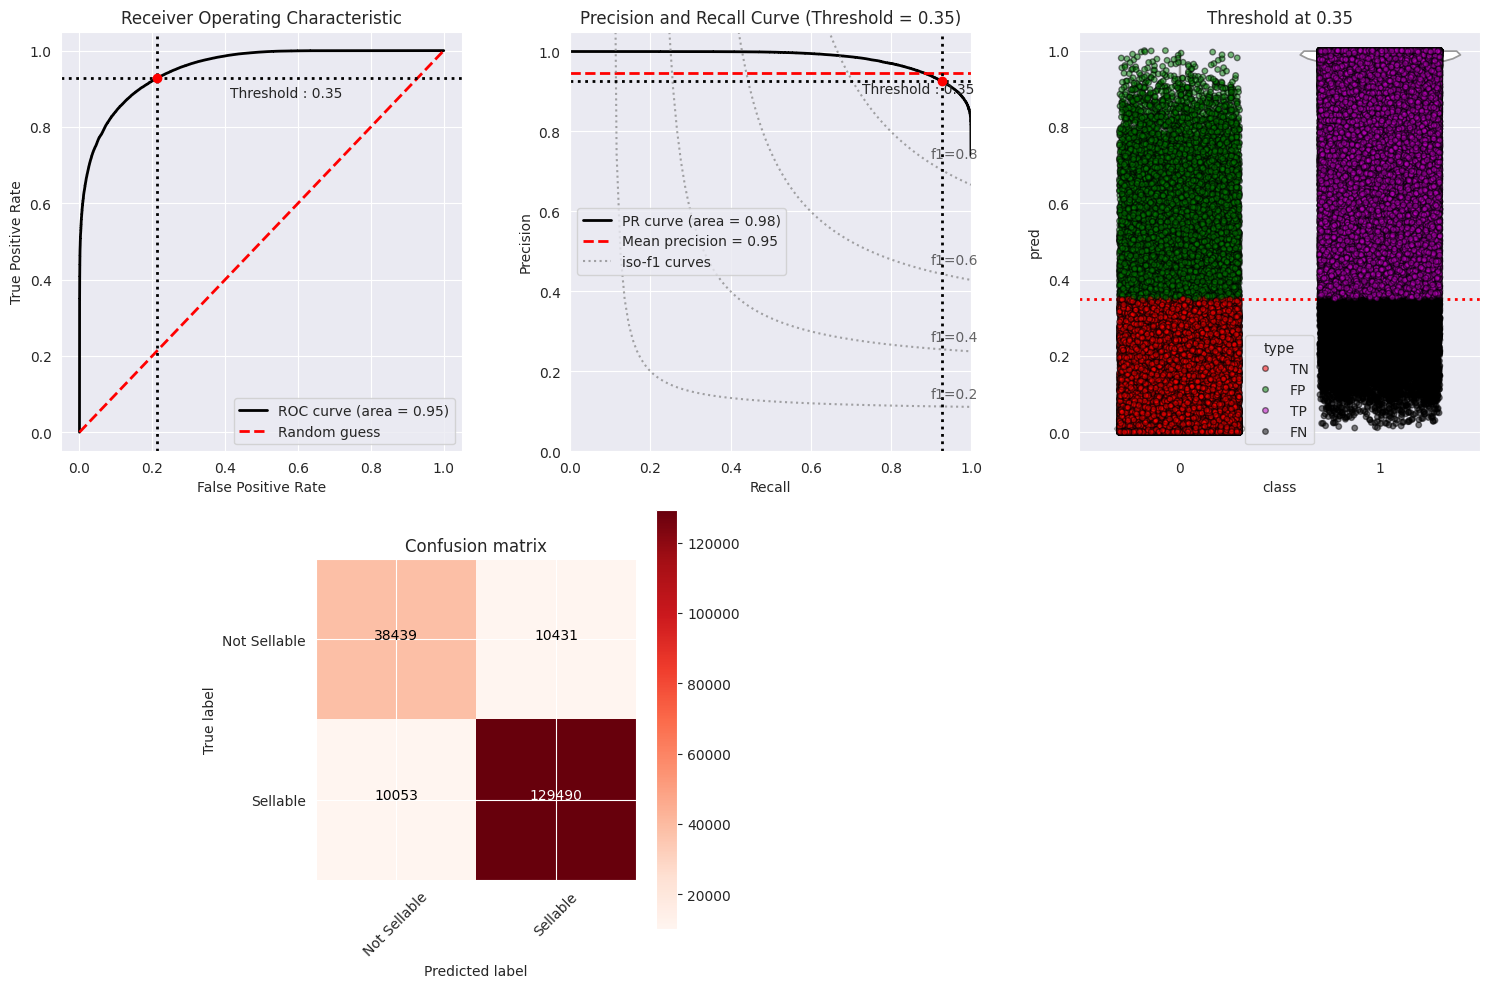

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

Not Sellable       0.79      0.79      0.79     48870
    Sellable       0.93      0.93      0.93    139543

    accuracy                           0.89    188413
   macro avg       0.86      0.86      0.86    188413
weighted avg       0.89      0.89      0.89    188413



In [ ]:
plot_metrics_report(y_val, pred_probs, t = 0.35)

In [ ]:
joblib.dump(X_val, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/X_val_sales_prob.pkl')

['/content/drive/MyDrive/PSI_Modeling_Data/Fern/X_val_sales_prob.pkl']

In [ ]:
total_inv_after_sampled = total_inv_after_sampled_copy

In [ ]:
train_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'total_units', 'shelf_life_remaining_days',
              'time', 'listing_condition', 'retail_price_per_unit_usd', 'order_price_per_unit_usd', 'domestic_export']
cat_cols = ['sku_number', 'brand', 'product_category', 'product_subcategory', 'seller_name', 'listing_condition', 'domestic_export']

print(total_inv_after_sampled[train_cols].duplicated().sum())
total_inv_after_sampled = total_inv_after_sampled.drop_duplicates(subset = train_cols)
total_inv_after_sampled = total_inv_after_sampled[~total_inv_after_sampled['product_category'].isnull()]

target_col = 'sellability'


# 3. Stratified split
X = total_inv_after_sampled[train_cols]
y = total_inv_after_sampled[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Compute class weights (inverse of class frequencies)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. Prepare CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_cols, weight=[class_weights_dict[label] for label in y_train])
val_pool = Pool(X_val, y_val, cat_features=cat_cols)


# 6. Model parameters
domestic_export_price_model_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.3,
    'colsample_bylevel': 0.6,
    'depth': 4,
    'min_data_in_leaf': 20,
    'subsample': 0.6,
    'od_wait': 30,
    'custom_metric': 'AUC:hints=skip_train~false',
    'random_seed': 42
}

domestic_export_price_model = CatBoostClassifier(**domestic_export_price_model_params, iterations = 1000)
domestic_export_price_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
pred_probs = domestic_export_price_model.predict_proba(X_val)

1240247
0:	learn: 0.6417850	test: 0.6393813	best: 0.6393813 (0)	total: 975ms	remaining: 16m 13s
1:	learn: 0.6156192	test: 0.6022647	best: 0.6022647 (1)	total: 1.92s	remaining: 15m 56s
2:	learn: 0.5930101	test: 0.5740804	best: 0.5740804 (2)	total: 2.66s	remaining: 14m 45s
3:	learn: 0.5779458	test: 0.5591949	best: 0.5591949 (3)	total: 3.46s	remaining: 14m 20s
4:	learn: 0.5662020	test: 0.5450835	best: 0.5450835 (4)	total: 4.44s	remaining: 14m 43s
5:	learn: 0.5588935	test: 0.5390028	best: 0.5390028 (5)	total: 5.42s	remaining: 14m 58s
6:	learn: 0.5483088	test: 0.5287990	best: 0.5287990 (6)	total: 7.15s	remaining: 16m 53s
7:	learn: 0.5368885	test: 0.5143735	best: 0.5143735 (7)	total: 8.6s	remaining: 17m 46s
8:	learn: 0.5271381	test: 0.5011480	best: 0.5011480 (8)	total: 9.63s	remaining: 17m 40s
9:	learn: 0.5199684	test: 0.4958216	best: 0.4958216 (9)	total: 10.4s	remaining: 17m 13s
10:	learn: 0.5150721	test: 0.4895025	best: 0.4895025 (10)	total: 11.2s	remaining: 16m 46s
11:	learn: 0.5063375	te

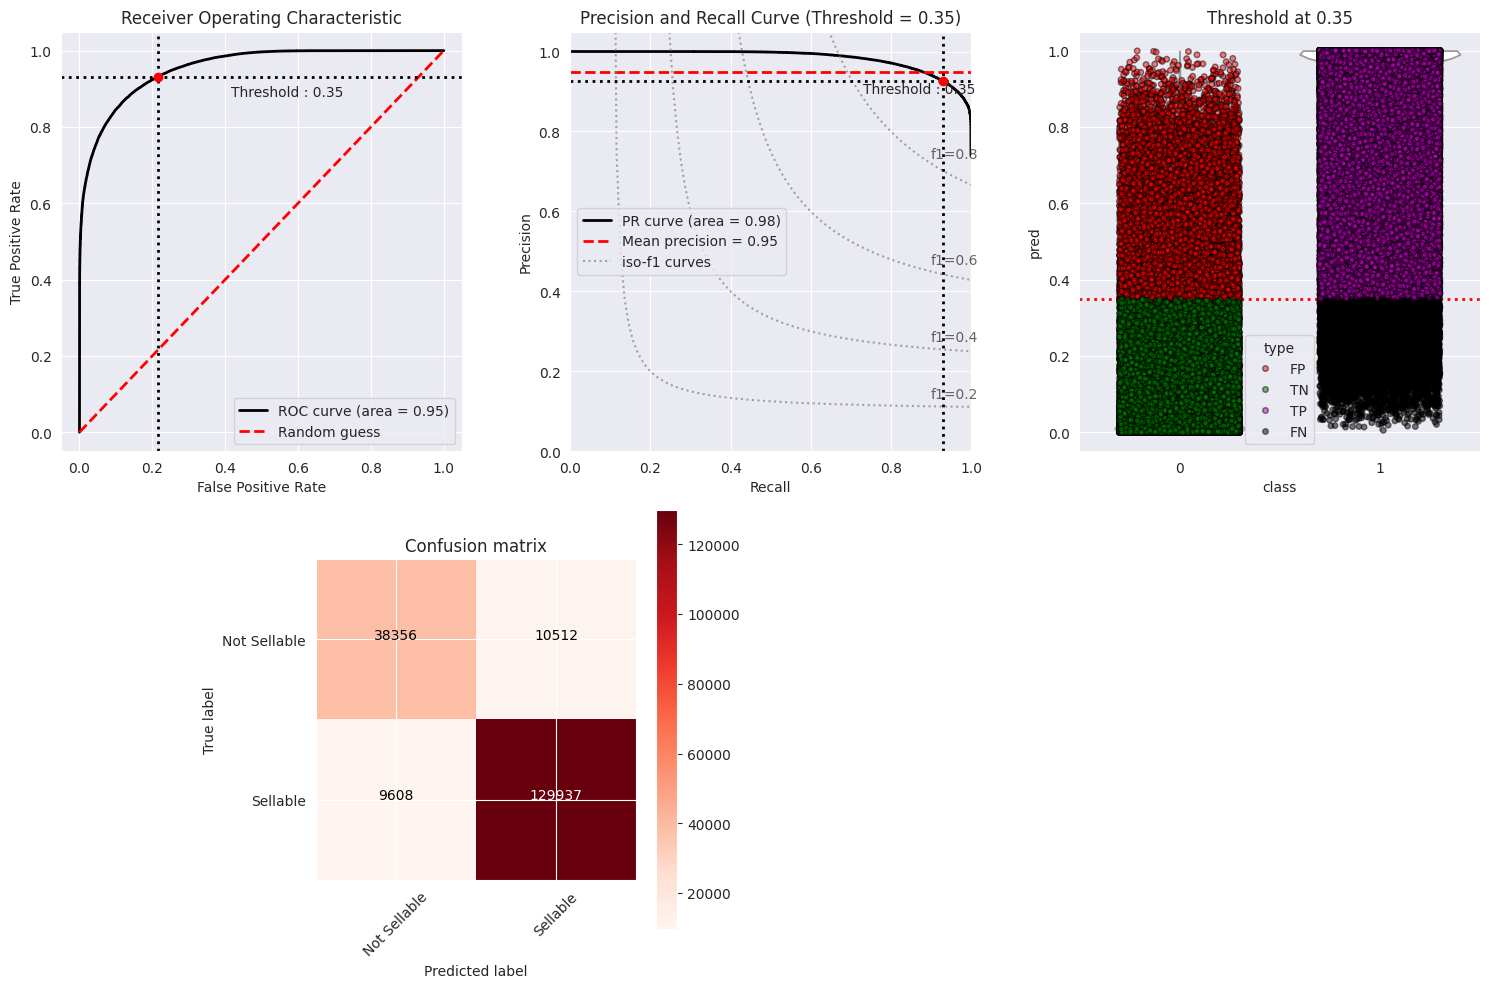

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

Not Sellable       0.80      0.78      0.79     48868
    Sellable       0.93      0.93      0.93    139545

    accuracy                           0.89    188413
   macro avg       0.86      0.86      0.86    188413
weighted avg       0.89      0.89      0.89    188413



In [ ]:
plot_metrics_report(y_val, pred_probs, t = 0.35)

In [ ]:
joblib.dump(X_val, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/X_val_domestic_export.pkl')

['/content/drive/MyDrive/PSI_Modeling_Data/Fern/X_val_domestic_export.pkl']

In [ ]:
# def dump_files_for_inference_pipeline():
#   print('Dumping files for inference later ...')
#   joblib.dump(sales_prob_price_model, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/sales_prob_price_model.pkl')
#   joblib.dump(domestic_export_price_model, '/content/drive/MyDrive/PSI_Modeling_Data/Fern/domestic_export_price_model.pkl')

In [ ]:
# dump_files_for_inference_pipeline()